# AI-Medic Assignment 3

Name: Mohammad Arabzadeh  
Email: a.mohamad7824@gmail.com

In this project, I'll train a CNN model based on VGG for the Derma MNIST dataset.  
Because the dataset is highly imbalanced, it is possible to get extremely high accuracies for more populated classes easily. But my goal in this project, is to get as high as possible accuracies for as many as possible classes. 

## 1. Loading the Data

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.math import exp

from sklearn.metrics import classification_report

In [ ]:
## Downloading the dataset
!wget -O Data.npz https://zenodo.org/record/4269852/files/dermamnist.npz?download=1

--2021-09-24 16:26:37--  https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘Data.npz’

Data.npz            100%[===================>]  18.81M  13.2MB/s    in 1.4s    

2021-09-24 16:26:40 (13.2 MB/s) - ‘Data.npz’ saved [19725078/19725078]



In [ ]:
## Descriptions for labels
meta = {0: "actinic keratoses and intraepithelial carcinoma", 
        1: "basal cell carcinoma",
        2: "benign keratosis-like lesions",
        3: "dermatofibroma",
        4: "melanoma",
        5: "melanocytic nevi",
        6: "vascular lesions"}

In [ ]:
## Loading the dataset
data = np.load('Data.npz')

In [ ]:
## Contents of the downloaded file
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


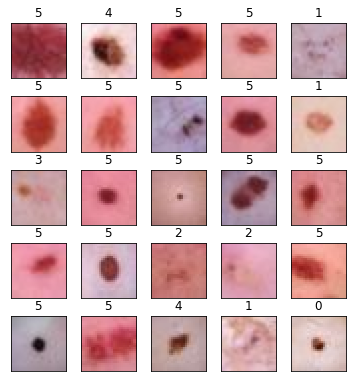

In [ ]:
## Looking at some of the images
rand_idx = np.array(np.random.rand(5*5) * data['train_images'].shape[0], 
                    dtype='int')

fig, axs = plt.subplots(5, 5)
for n, idx in enumerate(rand_idx):
  axs[n//5, n%5].imshow(data['train_images'][idx])
  axs[n//5, n%5].set_title(int(data['train_labels'][idx]))
  axs[n//5, n%5].set_xticks([])
  axs[n//5, n%5].set_yticks([])

plt.tight_layout(pad=-0.5)
fig.set_figheight(5)
fig.set_figwidth(5)

Text(0.5, 1.0, 'Percentage of Each Label Count')

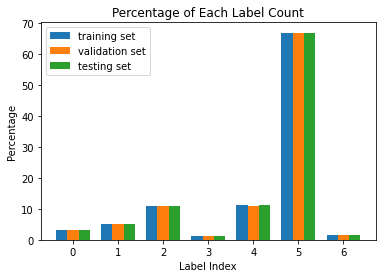

In [ ]:
## Distribution of classes
fig, axs = plt.subplots()
width = 0.25 # width of each bar

idx, train_counts = np.unique(data['train_labels'], return_counts=True)
axs.bar(idx - width, 100*train_counts/data['train_labels'].shape[0], 
        width, label='training set')

idx, val_counts = np.unique(data['val_labels'], return_counts=True)
axs.bar(idx, 100*val_counts/data['val_labels'].shape[0], 
        width, label='validation set')

idx, test_counts = np.unique(data['test_labels'], return_counts=True)
axs.bar(idx + width, 100*test_counts/data['test_labels'].shape[0], 
        width, label='testing set')

axs.legend()
axs.set_ylabel('Percentage')
axs.set_xlabel('Label Index')
axs.set_title('Percentage of Each Label Count')

We can see that most of the images are in class 5, and there are very little number of images in classes 0, 3, and 6.  
I'll try to fix this issue in the next sections. 

## 2. Preprocessing

### 1. Normalization

Based on [this article](https://machinelearningmastery.com/best-practices-for-preparing-and-augmenting-image-data-for-convolutional-neural-networks/) in VGG, the only data preprocessing was this: "The only preprocessing we do is subtracting the mean RGB value, computed on the training set, from each pixel." So I won't do anything else than that. 

In [ ]:
pre_process_mean = data['train_images'].mean()
print(pre_process_mean)

158.32006671656816


In [ ]:
X_train = (data['train_images'] - pre_process_mean) / 255
X_val = (data['val_images'] - pre_process_mean) / 255
X_test = (data['test_images'] - pre_process_mean) / 255

y_train = data['train_labels'].reshape(-1,)
y_val = data['val_labels'].reshape(-1,)
y_test = data['test_labels'].reshape(-1,)

# Y_train = to_categorical(y_train)
# Y_val = to_categorical(y_val)
# Y_test = to_categorical(y_test)

### 2. Train-Validation Reshuffling

I'll reshuffle the train and validation sets to be sure about their randomness. The reason I'm doing this will be more obvious in the next sections. 

In [ ]:
def split_train_val(X, y):
  def shuffle(X, y):
    shuffle_idx = np.arange(len(y))
    np.random.shuffle(shuffle_idx)
    return X[shuffle_idx], y[shuffle_idx]

  X, y = shuffle(X, y)

  split_ratio = 0.13

  X_train = np.empty((0, 28, 28, 3))
  X_val = np.empty((0, 28, 28, 3))
  y_train = np.empty(0)
  y_val = np.empty(0)

  for label in np.unique(y):
    idx = np.where(y==label)[0]
    split = int(split_ratio*len(idx))
    X_train = np.append(X_train, X[idx[split:]], axis=0)
    X_val = np.append(X_val, X[idx[:split]], axis=0)
    y_train = np.append(y_train, y[idx[split:]])
    y_val = np.append(y_val, y[idx[:split]])

  X_train, y_train = shuffle(X_train, y_train)
  X_val, y_val = shuffle(X_val, y_val)
  
  return X_train, X_val, y_train, y_val

In [ ]:
## Join train and validation sets
X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

## Reshuffle train and validation sets
X_train, X_val, y_train, y_val = split_train_val(X, y)
Y_train = to_categorical(y_train)
Y_val = to_categorical(y_val)
Y_test = to_categorical(y_test)

In [ ]:
print("   Train \t\t Validation \t\t Test")
print("   ---------------------------------------------------------------")
print("X", end='  ')
print(X_train.shape, '\t', X_val.shape, '\t', X_test.shape)
print("Y", end='  ')
print(Y_train.shape, '\t\t', Y_val.shape, '\t\t', Y_test.shape)

   Train 		 Validation 		 Test
   ---------------------------------------------------------------
X  (6973, 28, 28, 3) 	 (1037, 28, 28, 3) 	 (2005, 28, 28, 3)
Y  (6973, 7) 		 (1037, 7) 		 (2005, 7)


### 3. Fixing Imbalanceness

For training the model in this section, the data was only devided by 255 (no mean normalization).


With these parameters, we train the model and see the results: 
batch_size=32, epochs=20
```
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X[0].shape))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
```

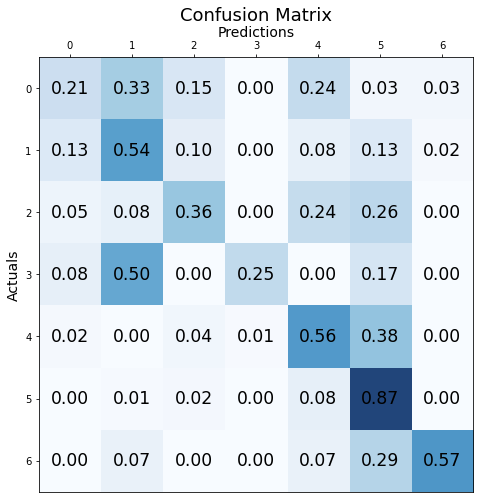

The validation accuracy is 0.73 and based on the learning curve, the model was overfit. Also we see that the confusion matrix for validation dataset is very awful! Because we are trying to get high accuracies for as many classes as possible. 

#### 1. Cost-Sensitive Learning

To fix the imbalenceness of the dataset, based on [this article](https://machinelearningmastery.com/cost-sensitive-neural-network-for-imbalanced-classification/), we use the following code which gives us integer values for the class_weight parameter. 

```
weights = dict(zip(idx, 
                   np.around((1/train_counts)*train_counts.max()).astype(int)))
```



if we train the model with these weights, the validation accuracy becomes 0.60 and the confusion matrix will be as follows: 

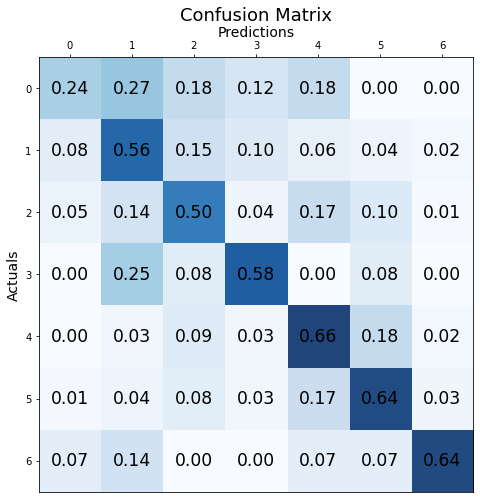

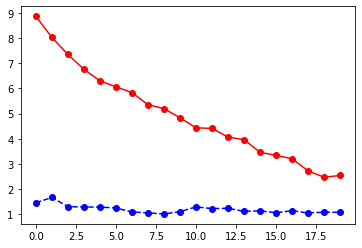

Based on the confusion matrix, the model has become so much better in predicting all classes. Also based on the learning curve, we see that the model is not overfitting as it was before. 

Another method for calculating class_weight parameter is suggested in [this article](https://tensorflow.google.cn/tutorials/structured_data/imbalanced_data#class_weights )

```
weights = dict(zip(idx, (1/train_counts)*train_counts.mean()))
```
Training the model this time, will give us 0.57 validation accuracy and the following confusion matrix and learning curve. 


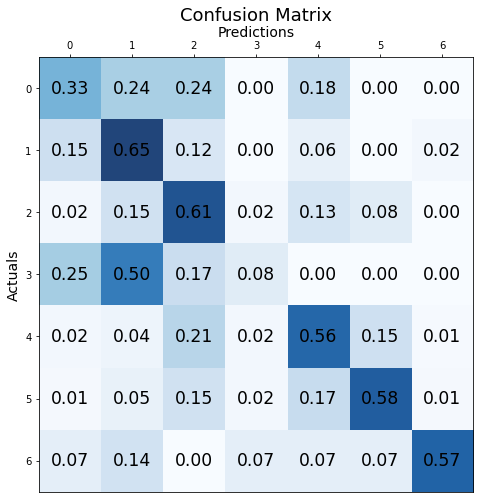

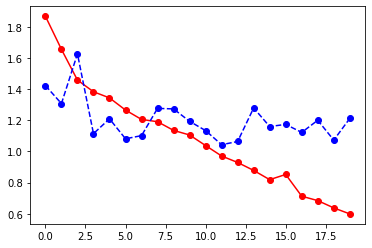

The confusion matrix is not as good as the first one, and the model is overfit.  

#### 2. Oversampling

Based on [this article](https://tensorflow.google.cn/tutorials/structured_data/imbalanced_data#oversampling), We oversample all classes to be of the same length as class 5: 



```
def over_sample(X, y):
  labels, counts = np.unique(y, return_counts=True)

  arranged_X = []
  for idx in labels:
    arranged_X.append(X[np.where(y==idx)[0]])

  resampled_arranged_X = []
  for idx in labels:
    choices = np.random.choice(np.arange(len(arranged_X[idx])), 
                               counts.max())
    resampled_arranged_X.append(arranged_X[idx][choices])

  resampled_X = np.concatenate(np.array(resampled_arranged_X), axis=0)
  resampled_y = np.repeat(labels, counts.max())

  order = np.arange(len(resampled_y))
  np.random.shuffle(order)
  resampled_X = resampled_X[order]
  resampled_y = resampled_y[order]

  return resampled_X, resampled_y
  ```



Using the oversampled data, we get the following results:  
val acc = 0.69

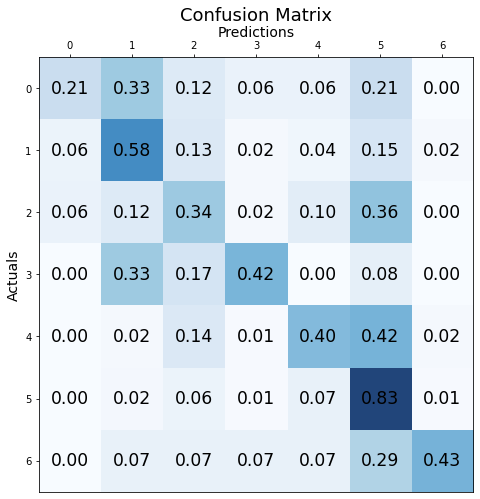

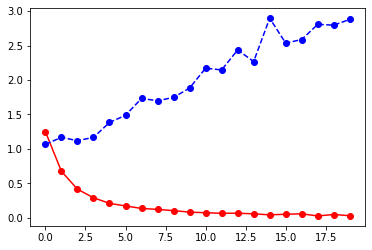

The model is overfit and the confusion matrix hasn't improved much comparing to the not oversampled data.  
This concludes that we'd better use the cost-sensitive method for handling the imbalanced data for this dataset. 

#### 3. Final Code for Fixing The Imbalanceness

In [ ]:
idx, train_counts = np.unique(y_train, return_counts=True)

weights = dict(zip(idx.astype(int), 
                   np.around((1/train_counts)*train_counts.max()).astype(int)))
print(weights)

{0: 20, 1: 13, 2: 6, 3: 58, 4: 6, 5: 1, 6: 47}


## 3. Model Structure and Hyperparameter Tuning

### 1. Training the Model on a Simple Architecture

We start with a simple model based on the VGG:

```
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X[0].shape))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X, Y, batch_size=32, epochs=30, validation_data=(X_val, Y_val), class_weight=weights)
```



Now we draw the loss for train (red) and validation (blue) sets:

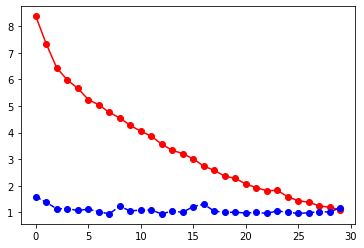

It seems like the validation dataset is easier to predict than the training dataset [[Based on this article](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/)]. Let's randomize the training and validation dataset and see the results again. 

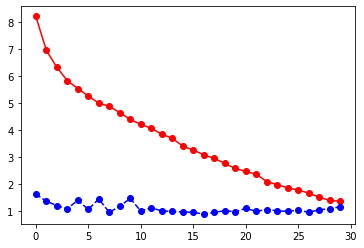

No change is observable after reshuffling the training and validation datasets. So the small validation loss must be because of the class_weight provided to the model.  
Also if we let the mdoel train for more epochs, we'll see that the validation loss will go up and the model gets overfit: 

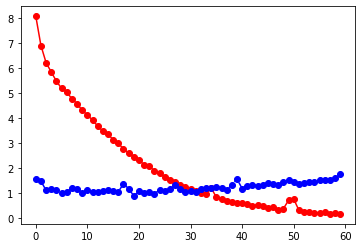

### 2. Weight Initialization Methods

A good weight initialization can improve the model drastically. I'll use three different initializers and see the loss curves. 

Golort Uniform:

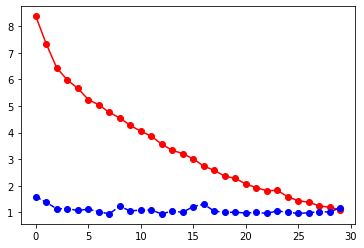

Golort Normal:

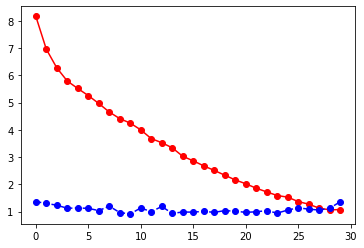

He:

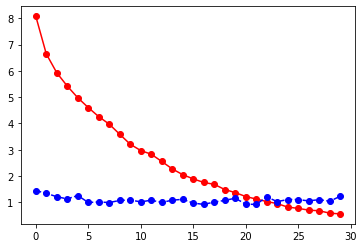

It seems like different weight initializers don't affect this model. So I'll just keep the default initializer which is "Golort Uniform". 

### 3. Learning Rate

Using lr=0.001 with Adam optimizer, we get this result:

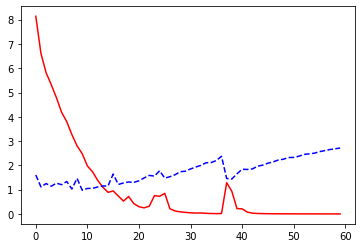

the training is good except for some spikes in the middle. We may be able to deal with this issue by using learning rate scheduler or changing the optimizer.  
For example by using the below scheduler, we get a relatively better curve. 


```
def scheduler(epoch, lr):
  if epoch < 14:
    return lr
  else:
    return lr * exp(-0.1)

callback = LearningRateScheduler(scheduler)
```



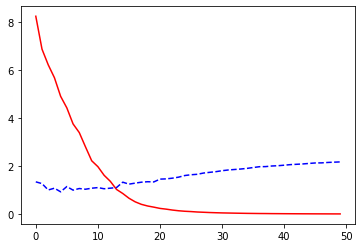

### 4. The Overfitting Issue

Before making the model more complex, we need to solve the overfitting issue. Because more complex models can lead to a phenomenon known as overfitting [[See this](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/)].  
For example, if I use L2 regularization for all layers, and add a dropout layer before classification, I'll get a somewhat better learning curve.  
I'll tune the regularization parameters after choosing the best model architecture. 


```
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X[0].shape, kernel_regularizer=l2(0.001)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPool2D((2, 2), strides=(2, 2)))


model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))
```



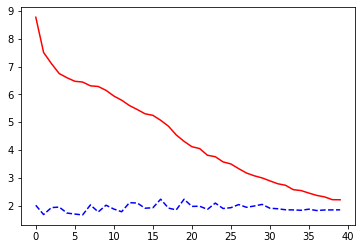

### 5. Choosing the Best Architecture

First, I'll compare the accuracy curves for 25 epochs for the following CNN structures which are based on the VGG (All kernel sizes are (3, 3), and pool sizes are (2, 2)):  
* conv 16 | conv 16 | max pool
* conv 32 | conv 32 | max pool
* conv 32 | conv 32 | max pool || conv 64 | conv 64 | max pool
* conv 32 | conv 32 | max pool || conv 64 | conv 64 | max pool || conv 128 | conv 128 | max pool

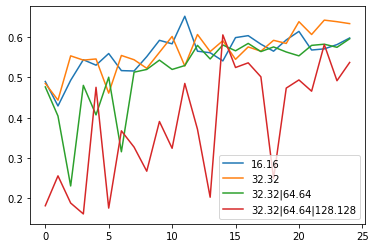

The (conv 32 | conv 32 | max pool) seems to be the best so far. Let's compare some othe structures with this one: 
* conv 32 | conv 32 | max pool
* conv 32 | conv 32 | max pool || conv 64 | max pool
* conv 32 | conv 32 | max pool || conv 64 | conv 64 | max pool
* conv 32 | conv 32 | max pool || conv 64 | conv 64 | conv 64 | max pool

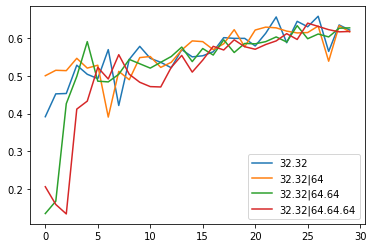

The curves are so close, but the (conv 32 | conv 32 | max pool || conv 64 | conv 64 | max pool) seems to have the least fluctuations. So I'll pick this one.  
Now let's check different fully connected structures for this CNN. For now, I'm using a Flatten() layer between the CNN and the fully connected layers.  
First, I put one fully connected layer with different numbers or neurons: 


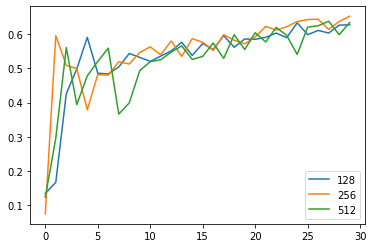

The accuracy curves are so close; but 256 neurons seems to be higher than others.  
I'll add another layer to see the results: 

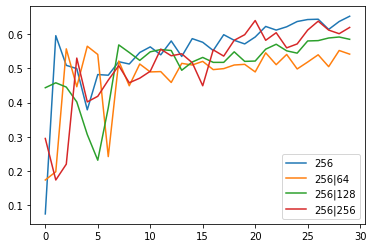

Based on these accuracy curves, one layer with 256 neurons seems to be the best choice. 

### 6. Comparing Different Optimizers

I tested different optimizers, and these three seemed to have the best results:  
* Adam 
* Adamax 
* SGD  

I'll first find the best hyperparameters for each one of these optimizers, and then compare them with each other. 

#### 1. Adam

I'll choose different learning rates for Adam and compare the training loss curves: 

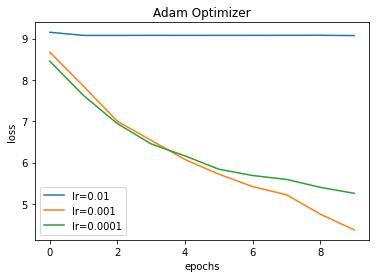

Now with lr=0.001, I'll compare different values for beta_1 parameter: 

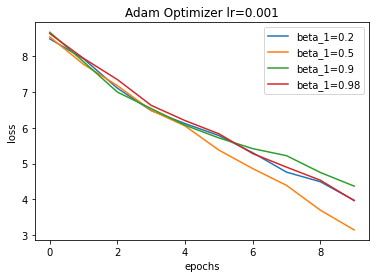

So the best parameters for Adam are: lr=0.001, beta_1=0.5.  
Lets also check if turning AMSGrad to True will improve the results: 

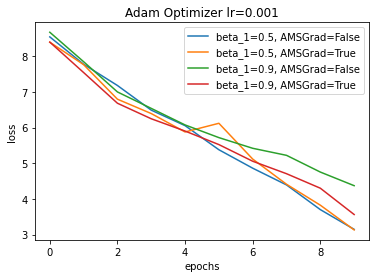

The answer is no. So we'll stick with AMSGrad=False. 

#### 2. Adamax

I'll choose different learning rates for Adamax and compare the training loss curves:

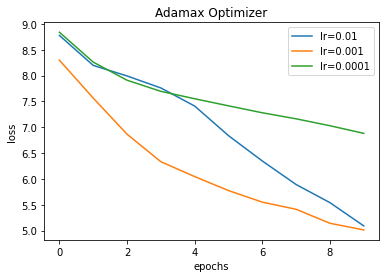

Now with lr=0.001, I'll compare different values for beta_1 parameter:

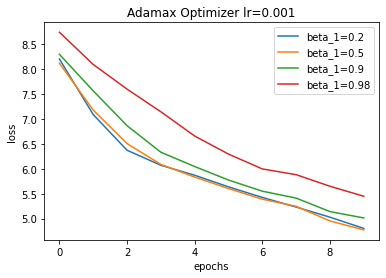

beta_1= 0.2 or 0.5 are almost identical. I'll choose beta_1=0.5. 

#### 3. SGD

I'll choose different learning rates for SGD and compare the training loss curves:

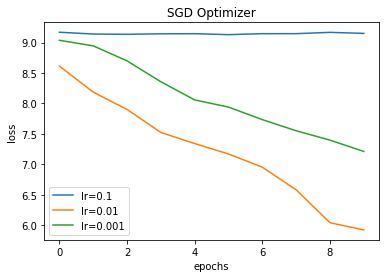

Now with lr=0.01, I'll compare different values for momentum parameter:

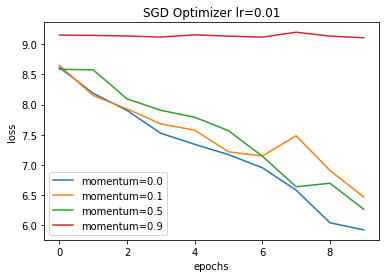

momentum set to 0.0 seems to be the best choice. 

#### 4. Comparing the Three Optimizers

Now with these tuned values, let's compare the three optimizers: 

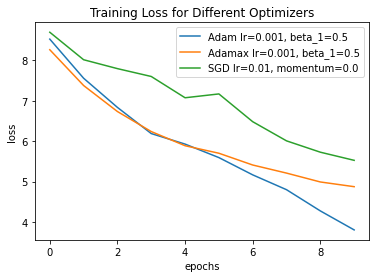

Adam is the obvious winner for this model. 

### 7. Training the New Model

Now that we have the architecture and the optimizer, let's train the model again. I'm not using any regularization or learning rate scheduler. 

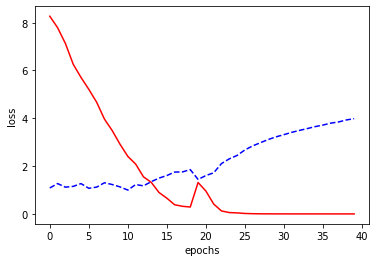

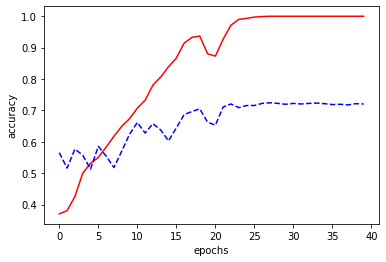

To fix the spikes in the curves, I'll add the following scheduler callback: 


```
def scheduler(epoch, lr):
  if epoch < 17:
    return lr
  else:
    return lr * exp(-0.05)

callback = LearningRateScheduler(scheduler)
```


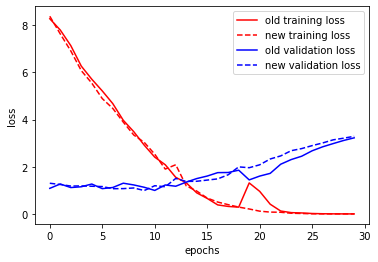

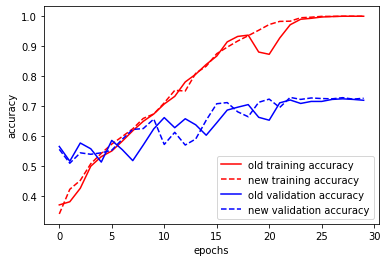

In the next section, I'll try to fix the overfitting issue with different regularization methods. 

### 8. Choosing the Best Regularization

#### 1. Batch Normalization

Based on [this article](https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html), the best practice for regularizing CNN layers is batch normalization.  
I'll add batch normalization before activation functions of the CNN layers: 

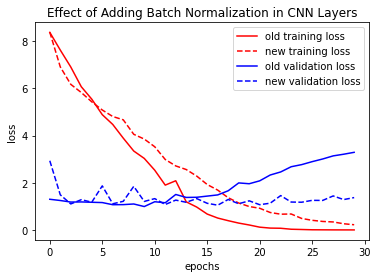

We see that the validation loss is no longer increasing and is somewhat fixed. 

#### 2. L2 Regularization

Now I'll add L2 Regularizations to the batch normalized CNN layers.  
First, I'll try l2(0.01): 


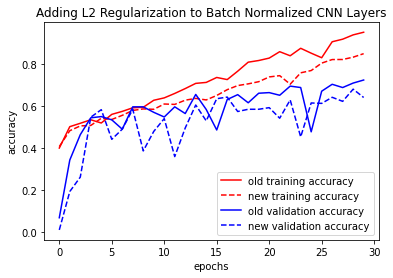

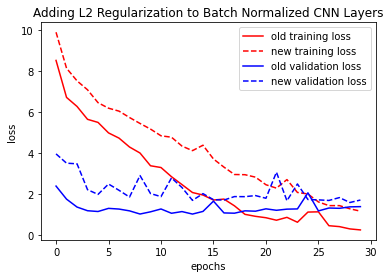

The model hasn't improved; val accuracy is lower and val loss is higher than before.  
Let's also try l2(0.001): 

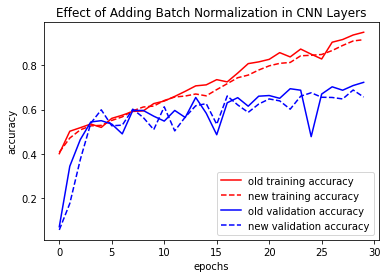

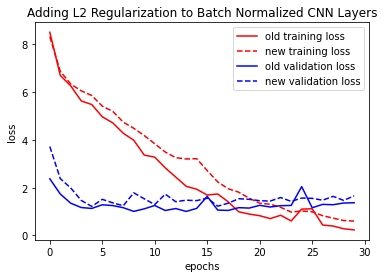

We have the same issue again. We'll avoid using L2 regularizations for this model. 

#### 3. Global Poolings

Based on [this article](https://www.machinecurve.com/index.php/2020/01/30/what-are-max-pooling-average-pooling-global-max-pooling-and-global-average-pooling/#max-pooling), using global max pooling or global average pooling instead of the flatten layer, may improve the model and even replace the fully connected layers.  
I've tested different structures and recorded the "mean accuracy of all classes" and "standard deviation of accuracies of all classes":  

|Structure               |mean |std  |
|:-----------------------|:----|:----|
|flatten with dense      |46.29|17.96|
|global avg with dense   |57.14|8.11 |
|global avg without dense|51.86|7.88 |
|global max with dense   |51.29|16.42|
|global max without dense|48.86|15.75|

Having lower std values, ensures the model to have good accuracies for all classes.  
Based on these results, "global avg with dense", "global avg without dense", and "global max with dense" seem to have relatively better performances.  
I'll compare these three in the following figure: 

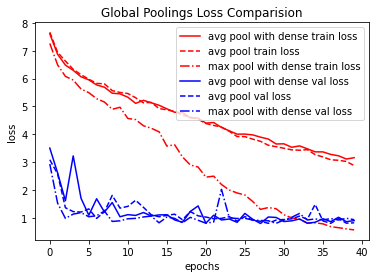

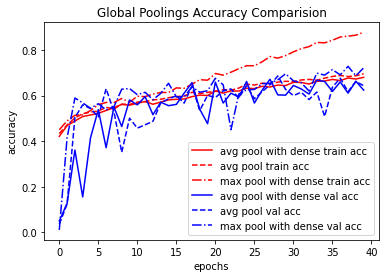

I'll choose  "global avg with dense" and "global max with dense" to investigate them further. 

##### 1. Getting the Best Global Poolings

For the global average pooling with dense, I'll increase the number of neurons on the fully connected dense layer to see if the training loss becomes faster or not: 

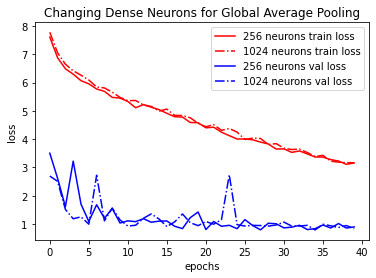

There seems to be no change.  
I'll let the model to train for more epochs to get a flattened training loss curve: 

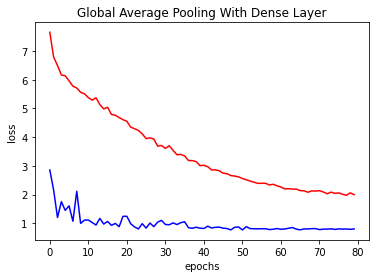

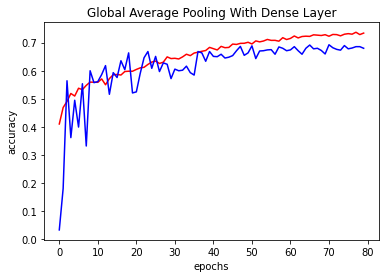

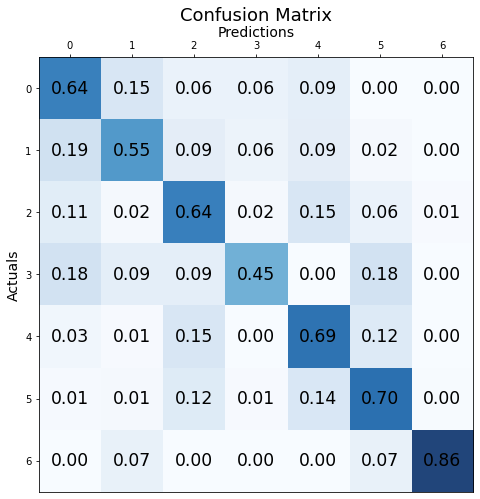

The learning curve seem to show an underfitting; but looking at the confusion matrix, it seems that the model is not performing badly on predicting the validation dataset. 

Now let's see the confusion matrix for the global max pooling with dense (there wasn't any need for further modifications). 

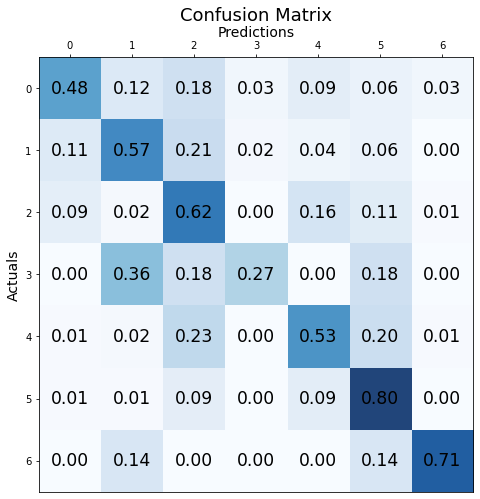

##### 2. Comparing the Two Global Pooling Methods

Loss and accuracy curves: 

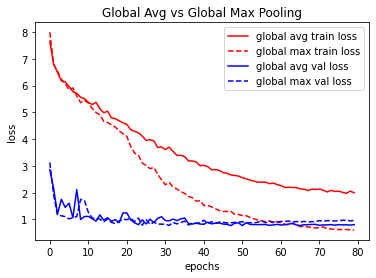

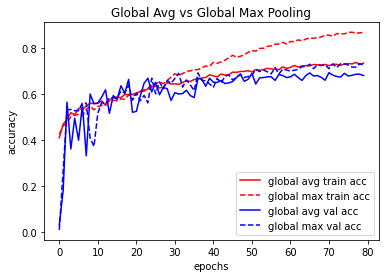

Based on these figures, it seems like the global max pooling is giving us better results. But let's compare the mean and std for accuracies of all classes:  

|Structure               |mean |std  |
|:-----------------------|:----|:----|
|global avg with dense   |64.71|11.85|
|global max with dense   |56.86|15.80|

It is obvious that the global average pooling with dense layer is the best choice. 

### 9. Activation Functions

I tested many activation functions, but the ReLU seemed to be the best one. The "mean accuracy of all classes" and "standard deviation of accuracies of all classes" for each activation function is listed in the following table:  

|Function |mean |std  |
|:--------|:----|:----|
|relu     |64.71|11.85|
|softplus |61.43|6.34 |
|tanh     |59.43|16.47|
|softmax  |51.14|19.56|
|sigmoid  |59.14|14.41|
|gelu     |55.14|14.53|
|swish    |62.63|14.74|



### 10. Kernel Size

We were using (3, 3) kernel size before. I'll change it to (5, 5) to see the results: 

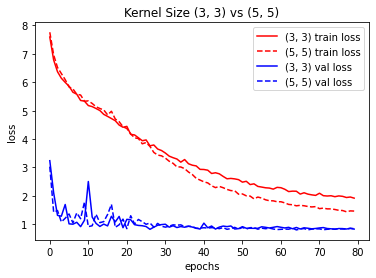

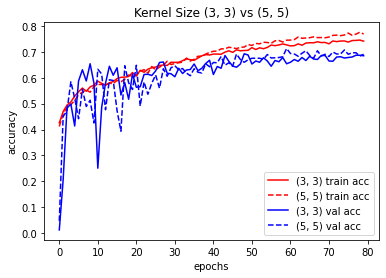

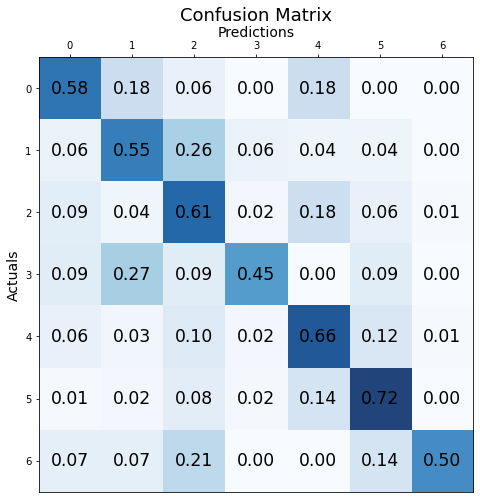

|Kernel Size|mean |std  |
|:----------|:----|:----|
|(3, 3)     |64.71|11.85|
|(5, 5)     |58.14|8.54 |

It seems like the model has somewhat improved. I'll further investigate this in the next sections. 

### 11. Pool Size

For the max pooling layers, I'll check if different pool sizes would improve the model.  
The results are recorded in the following tables: 
* Kernel size = (3, 3) 

|Pool Size  |mean |std  |
|:----------|:----|:----|
|(2, 2)     |64.71|11.85|
|(4, 4)     |66.57|13.93|
|(8, 8)     |57.57|12.90|

* Kernel size = (5, 5)

|Pool Size  |mean |std  |
|:----------|:----|:----|
|(2, 2)     |58.14|8.54 |
|(4, 4)     |57.00|16.20|

It seems like pool sizes (2, 2) and (4, 4) with kernel size of (3, 3) are the most promising ones.  
I also changed the stride values but the models only got worse; so I'll keep it unchanged. 


### 12. Max Pooling vs Average Pooling

With pool sizes (2, 2) and (4, 4) and kernel size of (3, 3), I check if changing the pooling method in CNN layers change the performance:  
* Pool size = (2, 2) 

|Pooling    |mean |std  |
|:----------|:----|:----|
|max        |64.71|11.85|
|avg        |60.57|7.58 |

* Pool size = (4, 4)

|Pooling    |mean |std  |
|:----------|:----|:----|
|max        |66.57|13.93|
|avg        |63.00|10.36|

The competition is very close! Looking at the confusion matrices, I decided to use average pooling with (4, 4) pool size. 

### 13. Final Model

The final model is as follows: 


```
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=X[0].shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D((4, 4), strides=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D((4, 4), strides=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.5), loss='categorical_crossentropy', metrics=['accuracy'])
```



## 4. Defining the Model

In [ ]:
def train_model(X_train=X_train, 
                Y_train=Y_train, 
                validation_data=(X_val, Y_val), 
                weights=weights,
                epochs=100):
  ## Defining the scheduler callback
  def scheduler(epoch, lr):
    if epoch < 17:
      return lr
    else:
      return lr * exp(-0.05)
  scheduler_callback = LearningRateScheduler(scheduler)
  ##################################

  ## Defining checkpoint callback to save the best model
  checkpoint_callback = ModelCheckpoint(
      filepath='tmp/checkpoint',
      monitor='val_accuracy', 
      mode='max', 
      save_best_only=True,
      verbose=1)
  ##################################
  
  ## Defining the model structure
  model = Sequential()

  # First CNN block
  model.add(Conv2D(32, (3, 3), padding='same', input_shape=X[0].shape))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(AveragePooling2D((4, 4), strides=(2, 2)))

  # Second CNN block
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(AveragePooling2D((4, 4), strides=(2, 2)))

  # Fully connected
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(7, activation='softmax'))
  ##################################

  ## Compiling the model
  model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.5),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  ##################################

  ## Fitting the model
  history = model.fit(X_train, Y_train, 
                       batch_size=32, 
                       epochs=epochs, 
                       callbacks=[scheduler_callback, checkpoint_callback], 
                       validation_data=validation_data, 
                       class_weight=weights)
  ##################################

  return model, history

## 5. Model Evaluation

### 1. Training the Model

In [ ]:
model, history = train_model()

Epoch 1/100
218/218 [==============================] - 4s 16ms/step - loss: 7.7489 - accuracy: 0.4160 - val_loss: 3.1697 - val_accuracy: 0.0444

Epoch 00001: val_accuracy improved from -inf to 0.04436, saving model to tmp/checkpoint
INFO:tensorflow:Assets written to: tmp/checkpoint/assets
Epoch 2/100
218/218 [==============================] - 3s 15ms/step - loss: 7.0338 - accuracy: 0.4669 - val_loss: 2.2941 - val_accuracy: 0.1871

Epoch 00002: val_accuracy improved from 0.04436 to 0.18708, saving model to tmp/checkpoint
INFO:tensorflow:Assets written to: tmp/checkpoint/assets
Epoch 3/100
218/218 [==============================] - 3s 15ms/step - loss: 6.5658 - accuracy: 0.4938 - val_loss: 1.5340 - val_accuracy: 0.3963

Epoch 00003: val_accuracy improved from 0.18708 to 0.39634, saving model to tmp/checkpoint
INFO:tensorflow:Assets written to: tmp/checkpoint/assets
Epoch 4/100
218/218 [==============================] - 3s 16ms/step - loss: 6.3016 - accuracy: 0.5031 - val_loss: 1.5631 - v

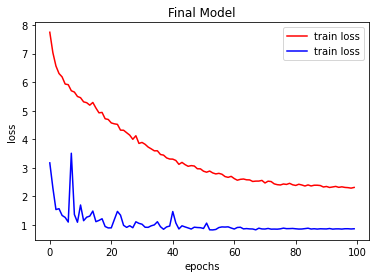

In [ ]:
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.title("Final Model")

plt.legend(['train loss', 'train loss',
            'val loss',   'val loss'])

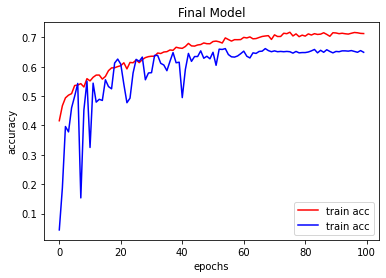

In [ ]:
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.title("Final Model")

plt.legend(['train acc', 'train acc',
            'val acc',   'val acc'])

### 2. Test Dataset Predictions

In [ ]:
y_true = y_test
y_pred = model.predict(X_test).argmax(axis=1)

print("First 10 labels:\t{}\nFirst 10 predictions:\t{}".format(y_true[:10], 
                                                               y_pred[:10]))

First 10 labels:	[5 3 4 0 5 5 5 4 5 2]
First 10 predictions:	[5 3 2 2 4 5 5 4 5 2]


### 3. Loss and Accuracy

In [ ]:
eval = model.evaluate(X_test, Y_test, verbose=0)
print("\nTesting loss = {:.2f}".format(eval[0]))
print("Testing accuracy = {:.2f}%".format(eval[1]*100))


Testing loss = 0.89
Testing accuracy = 65.59%


### 4. Classification Report

In [ ]:
class_rep = classification_report(y_true, y_pred)

print(class_rep)

              precision    recall  f1-score   support

           0       0.31      0.59      0.41        66
           1       0.41      0.62      0.50       103
           2       0.49      0.55      0.52       220
           3       0.23      0.43      0.30        23
           4       0.34      0.64      0.44       223
           5       0.95      0.68      0.79      1341
           6       0.44      0.86      0.58        29

    accuracy                           0.66      2005
   macro avg       0.45      0.63      0.51      2005
weighted avg       0.77      0.66      0.69      2005



### 5. Confusion Matrix

In [ ]:
def plot_conf_mat(model, X_test, Y_test): 
  """Plots the confusion matrix for a given model."""
  from sklearn.metrics import confusion_matrix

  y_true = Y_test.argmax(axis=1)
  y_pred = model.predict(X_test).argmax(axis=1)

  conf_mat = confusion_matrix(y_true, y_pred)
  norm_conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

  ## Plotting
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.matshow(norm_conf_mat, cmap=plt.cm.Blues, alpha=0.9)

  for i in range(norm_conf_mat.shape[0]):
      for j in range(norm_conf_mat.shape[1]):
          ax.text(x=j, y=i, s="{:.2f}".format(norm_conf_mat[i, j]), va='center', ha='center', size='xx-large')

  labels = np.unique(y_true)
  ax.set_xticks(labels)
  ax.set_yticks(labels)

  ax.xaxis.set_label_position('top')
  ax.xaxis.tick_top()
  plt.xlabel('Predictions', fontsize=14)
  plt.ylabel('Actuals', fontsize=14)
  plt.title('Confusion Matrix', fontsize=18, y=1.07)
  plt.show()

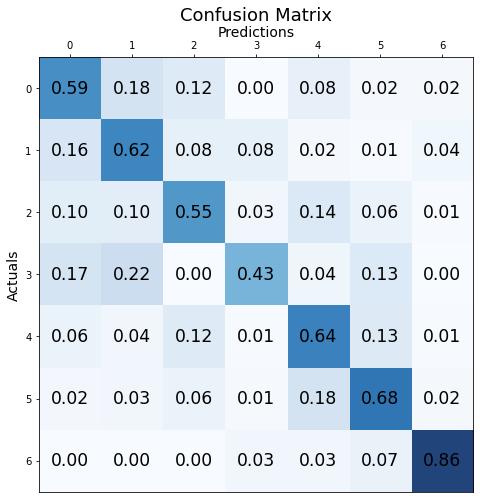

In [ ]:
plot_conf_mat(model, X_test, Y_test)